In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from lightgbm import LGBMClassifier

In [2]:
!pip install lightgbm


Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Load the data
train_data = pd.read_csv('train.csv')

In [4]:
# Display the first few rows of the DataFrame
train_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
# Check for missing values
train_data.isnull().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [6]:
# Check for duplicated values

duplicates = train_data.duplicated()

# Count the number of duplicated rows
num_duplicates = duplicates.sum()

print("Number of duplicated rows:", num_duplicates)


Number of duplicated rows: 0


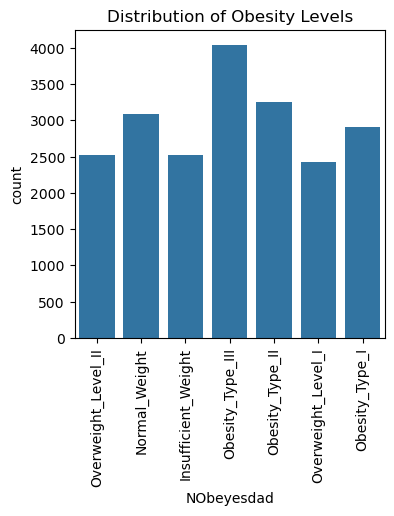

In [7]:
# Visualize the distribution of the target variable (NObeyesdad)

plt.figure(figsize=(4, 4))
sns.countplot(x='NObeyesdad', data=train_data)
plt.title('Distribution of Obesity Levels')
plt.xticks(rotation=90)
plt.show()


In [8]:
# Encode target variable into numerical labels
label_encoder = LabelEncoder()
train_data['NObeyesdad'] = label_encoder.fit_transform(train_data['NObeyesdad'])

In [9]:
# Split features and target variable

X = train_data.drop(columns=['NObeyesdad'])
y = train_data['NObeyesdad']


In [10]:
# Define categorical and numerical features

categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [11]:
# Split the data into training and validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [13]:
# Define the LGBM model
lgbm_model = LGBMClassifier()


In [14]:
# Define the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', lgbm_model)])


In [15]:
# Define hyperparameters for randomized search
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [3, 5, 7, 9, 11],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'classifier__subsample': [0.5, 0.7, 0.9, 1.0],
    'classifier__colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'classifier__min_child_samples': [10, 20, 30, 40, 50],
    'classifier__reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'classifier__reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'classifier__min_child_weight': [1e-3, 1e-2, 0.1, 1, 10]
}

In [16]:
# Perform randomized search cross-validation

random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, 
                                   n_iter=50, 
                                   cv=3, 
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs=-1)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 30
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Height',
                                                                                'Weight',
                                                                                'FCVC',
                                                                                'NCP',
                                                                                'CH2O',
                                                                                'FAF',
                                                                                'TUE']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Gender',
                                                                                'family_history_with_overweight',
                                                                                'FAVC',
                                                                                'CAEC',
                                                                                'SMOKE',...
                                                                      0.2,
                                                                      0.3],
                                        'classifier__max_depth': [3, 5, 7, 9,
                                                                  11],
                                        'classifier__min_child_samples': [10,
                                                                          20,
                                                                          30,
                                                                          40,
                                                                          50],
                                        'classifier__min_child_weight': [0.001,
                                                                         0.01,
                                                                         0.1, 1,
                                                                         10],
                                        'classifier__n_estimators': [100, 200,
                                                                     300, 400,
                                                                     500],
                                        'classifier__reg_alpha': [0.0, 0.1, 0.5,
                                                                  1.0],
                                        'classifier__reg_lambda': [0.0, 0.1,
                                                                   0.5, 1.0],
                                        'classifier__subsample': [0.5, 0.7, 0.9,
                                                                  1.0]},
                   random_state=42, verbose=2)

In [17]:
# Get the best parameters

best_params = random_search.best_params_
best_model = random_search.best_estimator_

In [18]:
# Define hyperparameters for randomized search
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [3, 5, 7, 9, 11],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'classifier__subsample': [0.5, 0.7, 0.9, 1.0],
    'classifier__colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'classifier__min_child_samples': [10, 20, 30, 40, 50],
    'classifier__reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'classifier__reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'classifier__min_child_weight': [1e-3, 1e-2, 0.1, 1, 10]
}

In [19]:
# Print the best parameters
print("Best Parameters:", best_params)

Best Parameters: {'classifier__subsample': 0.7, 'classifier__reg_lambda': 1.0, 'classifier__reg_alpha': 1.0, 'classifier__n_estimators': 200, 'classifier__min_child_weight': 0.001, 'classifier__min_child_samples': 20, 'classifier__max_depth': 9, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.5}


In [ ]:
# Evaluate the best model on the validation set
accuracy = best_model.score(X_test, y_test)
print("Validation Accuracy:", accuracy)

# best model on entire dataset
best_model.fit(X,y)

In [22]:
# Prepare test data

test_data = pd.read_csv('test.csv')

In [23]:
# Make predictions on test data
test_predictions = best_model.predict(test_data)

In [24]:
# Create submission dataframe
submission_df = pd.DataFrame({'id': test_data['id'], 
                              'NObeyesdad': label_encoder.inverse_transform(test_predictions)})

In [25]:
# Save submission dataframe to CSV
submission_df.to_csv('submission.csv', index=False)

In [26]:
import joblib

In [27]:
joblib.dump(best_model,'trained_model')

['trained_model']

In [28]:

joblib.dump(label_encoder,'label_encoder')

['label_encoder']

In [ ]:
import tkinter as tk
from tkinter import ttk
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib

# Load the label encoder for the target variable
label_encoder = LabelEncoder()
label_encoder.classes_ = pd.read_pickle('label_encoder')

# Load the saved model
best_model = joblib.load('trained_model')

def predict_obesity():
    # Get user input
    gender = gender_var.get()
    age = float(age_entry.get())
    height = float(height_entry.get())
    weight = float(weight_entry.get())
    family_history = family_history_var.get()
    favc = favc_var.get()
    fcvc = float(fcvc_entry.get())
    ncp = float(ncp_entry.get())
    caec = caec_var.get()
    smoke = smoke_var.get()
    ch2o = float(ch2o_entry.get())
    scc = scc_var.get()
    faf = float(faf_entry.get())
    tue = float(tue_entry.get())
    calc = calc_var.get()
    mtrans = mtrans_var.get()

    # Prepare input data
    data = pd.DataFrame({
        'Gender': [gender],
        'Age': [age],
        'Height': [height],
        'Weight': [weight],
        'family_history_with_overweight': [family_history],
        'FAVC': [favc],
        'FCVC': [fcvc],
        'NCP': [ncp],
        'CAEC': [caec],
        'SMOKE': [smoke],
        'CH2O': [ch2o],
        'SCC': [scc],
        'FAF': [faf],
        'TUE': [tue],
        'CALC': [calc],
        'MTRANS': [mtrans]
    })

    # Make prediction using the loaded model
    prediction = best_model.predict(data)
    result_label.config(text="Predicted obesity level: {}".format(label_encoder.inverse_transform(prediction)[0]))

# Create GUI
root = tk.Tk()
root.title("Obesity Prediction")

mainframe = ttk.Frame(root, padding="20")
mainframe.grid(column=0, row=0, sticky=(tk.N, tk.W, tk.E, tk.S))
mainframe.columnconfigure(0, weight=1)
mainframe.rowconfigure(0, weight=1)

# Create input fields for numerical columns
ttk.Label(mainframe, text="Gender:").grid(column=1, row=1, sticky=tk.W)
gender_var = tk.StringVar()
gender_combobox = ttk.Combobox(mainframe, width=15, textvariable=gender_var, values=['Male', 'Female'])
gender_combobox.grid(column=2, row=1, sticky=tk.W)

ttk.Label(mainframe, text="Age:").grid(column=1, row=2, sticky=tk.W)
age_entry = ttk.Entry(mainframe, width=15)
age_entry.grid(column=2, row=2, sticky=tk.W)

ttk.Label(mainframe, text="Height:").grid(column=1, row=3, sticky=tk.W)
height_entry = ttk.Entry(mainframe, width=15)
height_entry.grid(column=2, row=3, sticky=tk.W)

ttk.Label(mainframe, text="Weight:").grid(column=1, row=4, sticky=tk.W)
weight_entry = ttk.Entry(mainframe, width=15)
weight_entry.grid(column=2, row=4, sticky=tk.W)

ttk.Label(mainframe, text="family_history_with_overweight:").grid(column=1, row=5, sticky=tk.W)
family_history_var = tk.StringVar()
family_history_combobox = ttk.Combobox(mainframe, width=15, textvariable=family_history_var, values=['yes', 'no'])
family_history_combobox.grid(column=2, row=5, sticky=tk.W)

ttk.Label(mainframe, text="FAVC:").grid(column=1, row=6, sticky=tk.W)
favc_var = tk.StringVar()
favc_combobox = ttk.Combobox(mainframe, width=15, textvariable=favc_var, values=['yes', 'no'])
favc_combobox.grid(column=2, row=6, sticky=tk.W)

ttk.Label(mainframe, text="FCVC:").grid(column=1, row=7, sticky=tk.W)
fcvc_entry = ttk.Entry(mainframe, width=15)
fcvc_entry.grid(column=2, row=7, sticky=tk.W)

ttk.Label(mainframe, text="NCP:").grid(column=1, row=8, sticky=tk.W)
ncp_entry = ttk.Entry(mainframe, width=15)
ncp_entry.grid(column=2, row=8, sticky=tk.W)

ttk.Label(mainframe, text="CAEC:").grid(column=1, row=9, sticky=tk.W)
caec_var = tk.StringVar()
caec_combobox = ttk.Combobox(mainframe, width=15, textvariable=caec_var, values=['no', 'Sometimes', 'Frequently', 'Always'])
caec_combobox.grid(column=2, row=9, sticky=tk.W)

ttk.Label(mainframe, text="Smoke:").grid(column=1, row=10, sticky=tk.W)
smoke_var = tk.StringVar()
smoke_combobox = ttk.Combobox(mainframe, width=15, textvariable=smoke_var, values=['no', 'yes'])
smoke_combobox.grid(column=2, row=10, sticky=tk.W)

ttk.Label(mainframe, text="CH2O:").grid(column=1, row=11, sticky=tk.W)
ch2o_entry = ttk.Entry(mainframe, width=15)
ch2o_entry.grid(column=2, row=11, sticky=tk.W)

ttk.Label(mainframe, text="SCC:").grid(column=1, row=12, sticky=tk.W)
scc_var = tk.StringVar()
scc_combobox = ttk.Combobox(mainframe, width=15, textvariable=scc_var, values=['no', 'yes'])
scc_combobox.grid(column=2, row=12, sticky=tk.W)

ttk.Label(mainframe, text="FAF:").grid(column=1, row=13, sticky=tk.W)
faf_entry = ttk.Entry(mainframe, width=15)
faf_entry.grid(column=2, row=13, sticky=tk.W)

ttk.Label(mainframe, text="TUE:").grid(column=1, row=14, sticky=tk.W)
tue_entry = ttk.Entry(mainframe, width=15)
tue_entry.grid(column=2, row=14, sticky=tk.W)

ttk.Label(mainframe, text="CALC:").grid(column=1, row=15, sticky=tk.W)
calc_var = tk.StringVar()
calc_combobox = ttk.Combobox(mainframe, width=15, textvariable=calc_var, values=['no', 'Sometimes', 'Frequently', 'Always'])
calc_combobox.grid(column=2, row=15, sticky=tk.W)

ttk.Label(mainframe, text="MTRANS:").grid(column=1, row=16, sticky=tk.W)
mtrans_var = tk.StringVar()
mtrans_combobox = ttk.Combobox(mainframe, width=15, textvariable=mtrans_var, values=['Automobile', 'Bike', 'Motorbike', 'Public_Transportation', 'Walking'])
mtrans_combobox.grid(column=2, row=16, sticky=tk.W)

# Add a button to make prediction
ttk.Button(mainframe, text="Predict", command=predict_obesity).grid(column=2, row=17, sticky=tk.W)

# Add label to display result
result_label = ttk.Label(mainframe, text="")
result_label.grid(column=1, row=18, columnspan=2, sticky=tk.W)

root.mainloop()


In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
import joblib

# Function to load the trained model and perform prediction
def predict_and_save():
    # Load the trained model
    try:
        trained_model = joblib.load('trained_model')
    except FileNotFoundError:
        messagebox.showerror("Error", "Model not found. Please train a model first.")
        return
    
    # Browse for test data file
    file_path = filedialog.askopenfilename()
    if not file_path:
        messagebox.showerror("Error", "Please select a file.")
        return
    
    try:
        # Load the test data
        test_data = pd.read_csv(file_path)
        
        # Make predictions
        test_predictions = trained_model.predict(test_data)
        
        # Load the label encoder
        label_encoder = joblib.load('label_encoder')
        
        # Convert numerical labels back to original categories
        #predicted_categories = label_encoder.inverse_transform(predictions)
        
        # Create submission dataframe
        #submission_df = pd.DataFrame({'id': range(1, len(predicted_categories) + 1), 'NObeyesdad': predicted_categories})
        submission_df = pd.DataFrame({'id': test_data['id'], 
                'NObeyesdad': label_encoder.inverse_transform(test_predictions)})
        # Save submission dataframe to CSV
        submission_df.to_csv('submission.csv', index=False)
        
        messagebox.showinfo("Predictions", "Predictions have been made and saved as 'submission.csv'.")
    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {str(e)}")

# GUI Creation
window = tk.Tk()
window.title("Obesity Prediction")
window.geometry("300x100")

predict_button = tk.Button(window, text="Predict and Save", command=predict_and_save)
predict_button.pack()

window.mainloop()


In [ ]:
joblib.dump(best_model, 'trained_model')
joblib.dump(label_encoder, 'label_encoder')

In [ ]:
!python app.py

